# Visualiser for area28 metric data

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [452]:
# df = pd.read_json("data.json")
df = pd.read_csv("dummy.csv")
df = df.set_index('id')
df

,type,userId,sessionId,sceneId,timestamp,data
id,,,,,,
1,CORE_SCENE_JOIN,0,0,7,2020-01-03 13:35:35,"{'rating': None, 'rating_cat': None}"
2,CORE_SCENE_LEAVE,0,0,7,2020-01-03 16:26:43,"{'rating': None, 'rating_cat': None}"
3,CORE_SCENE_RATE,0,0,7,2020-01-03 16:27:13,"{'rating': 2, 'rating_cat': 'Cat4'}"
4,CORE_SCENE_JOIN,1,0,7,2020-01-03 11:44:43,"{'rating': None, 'rating_cat': None}"
5,CORE_SCENE_LEAVE,1,0,7,2020-01-03 14:11:38,"{'rating': None, 'rating_cat': None}"
...,...,...,...,...,...,...
169,CORE_SCENE_JOIN,8,6,0,2020-01-09 12:33:41,"{'rating': None, 'rating_cat': None}"
170,CORE_SCENE_LEAVE,8,6,0,2020-01-09 18:09:16,"{'rating': None, 'rating_cat': None}"
171,CORE_SCENE_RATE,8,6,0,2020-01-09 18:09:34,"{'rating': 0, 'rating_cat': 'Network'}"


In [453]:
import calendar

df_no_rating = df.drop(df[df['type'] == "CORE_SCENE_RATE"].index)

df_no_rating['datetime'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S') for d in df_no_rating['timestamp']]
durations = df_no_rating.groupby(['userId', 'sessionId'])['datetime'].diff()
df_no_rating['date'] = [dt.datetime.date(d) for d in df_no_rating['datetime']] 
df_no_rating['time'] = [dt.datetime.time(d) for d in df_no_rating['datetime']]
df_no_rating['weekday'] = [calendar.day_name[d.weekday()] for d in df_no_rating['datetime']]

df_no_rating['duration'] = durations
df_processed = df_no_rating[['userId', 'sessionId', 'date', 'duration', 'time', 'weekday', 'sceneId']].copy()
df_processed = df_processed.dropna()
df_processed

,userId,sessionId,date,duration,time,weekday,sceneId
id,,,,,,,
2,0,0,2020-01-03,0 days 02:51:08,16:26:43,Friday,7
5,1,0,2020-01-03,0 days 02:26:55,14:11:38,Friday,7
8,2,0,2020-01-03,0 days 04:50:45,14:57:35,Friday,7
10,3,0,2020-01-03,0 days 01:30:19,13:04:44,Friday,7
12,4,0,2020-01-03,0 days 00:58:13,11:41:05,Friday,7
...,...,...,...,...,...,...,...
162,5,6,2020-01-09,0 days 04:09:49,16:01:14,Thursday,0
165,6,6,2020-01-09,0 days 02:49:25,12:50:50,Thursday,0
168,7,6,2020-01-09,0 days 02:00:30,14:52:09,Thursday,0


In [454]:
df_no_rating.head()

,type,userId,sessionId,sceneId,timestamp,data,datetime,date,time,weekday,duration
id,,,,,,,,,,,
1,CORE_SCENE_JOIN,0,0,7,2020-01-03 13:35:35,"{'rating': None, 'rating_cat': None}",2020-01-03 13:35:35,2020-01-03,13:35:35,Friday,NaT
2,CORE_SCENE_LEAVE,0,0,7,2020-01-03 16:26:43,"{'rating': None, 'rating_cat': None}",2020-01-03 16:26:43,2020-01-03,16:26:43,Friday,0 days 02:51:08
4,CORE_SCENE_JOIN,1,0,7,2020-01-03 11:44:43,"{'rating': None, 'rating_cat': None}",2020-01-03 11:44:43,2020-01-03,11:44:43,Friday,NaT
5,CORE_SCENE_LEAVE,1,0,7,2020-01-03 14:11:38,"{'rating': None, 'rating_cat': None}",2020-01-03 14:11:38,2020-01-03,14:11:38,Friday,0 days 02:26:55
7,CORE_SCENE_JOIN,2,0,7,2020-01-03 10:06:50,"{'rating': None, 'rating_cat': None}",2020-01-03 10:06:50,2020-01-03,10:06:50,Friday,NaT


In [455]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install ipywidgets -q

In [456]:
import ipywidgets as widgets
menu = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       value='Week',
       description='Timeframe:')
menu

Dropdown(description='Timeframe:', index=1, options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Week'…

In [457]:
menu.value

'Week'

# Pie chart of time spent in different scenes

In [458]:
df_sessions = pd.DataFrame({'duration' : df_processed.groupby( [ "sceneId"] )['duration'].sum()}).reset_index()
df_sessions['duration_sec'] = [d.total_seconds() for d in df_sessions['duration']]
df_sessions

,sceneId,duration,duration_sec
0,0,1 days 00:07:55,86875.0
1,3,0 days 20:15:42,72942.0
2,6,0 days 17:58:19,64699.0
3,7,1 days 03:43:02,99782.0
4,12,1 days 03:40:32,99632.0
5,16,1 days 08:11:40,115900.0
6,18,0 days 22:47:15,82035.0


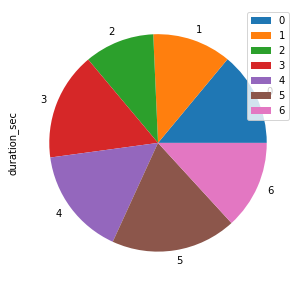

In [459]:
plot = df_sessions.plot.pie(y='duration_sec', figsize=(5, 5))

### Bar Chart showing how long users spent in sessions

<BarContainer object of 70 artists>

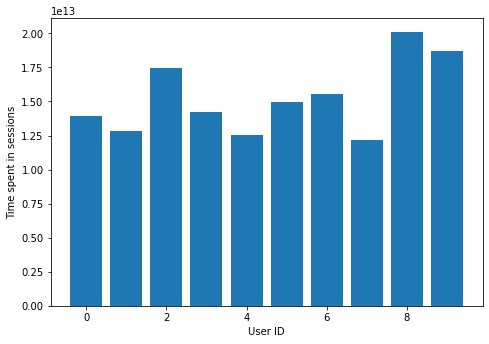

In [460]:
# df_processed.plot(x="userId", y=["times"])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Time spent in sessions')
ax.set_xlabel('User ID')
ax.bar(df_processed['userId'], df_processed['duration'])

# Heatmap showing time spent in session for each user during a week

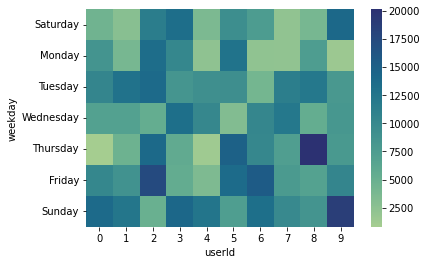

In [461]:
from pandas import DataFrame
import seaborn as sns
import time
%matplotlib inline

df_processed['seconds'] = [d.total_seconds() for d in df_processed['duration']]

df_processed_groupedbyID = pd.DataFrame({'seconds' : df_processed.groupby(['userId', 'weekday'])['seconds'].sum()}).reset_index()

df_heatmap = df_processed_groupedbyID.pivot(index='weekday', columns='userId', values='seconds')
df_heatmap.index = pd.CategoricalIndex(df_heatmap.index, categories= ['Saturday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday'])
df_heatmap.sort_index(level=0, inplace=True)

sns.heatmap(df_heatmap, annot=False, fmt="g", cmap='crest')
plt.show()

In [462]:
df_processed_groupedbyID.head()


,userId,weekday,seconds
0,0,Friday,10268.0
1,0,Monday,8561.0
2,0,Saturday,4458.0
3,0,Sunday,13912.0
4,0,Thursday,798.0


## Show ratings of users


In [463]:
df_rating = df.drop(df[df['type'] != "CORE_SCENE_RATE"].index)
df_rating.head()

,type,userId,sessionId,sceneId,timestamp,data
id,,,,,,
3,CORE_SCENE_RATE,0,0,7,2020-01-03 16:27:13,"{'rating': 2, 'rating_cat': 'Cat4'}"
6,CORE_SCENE_RATE,1,0,7,2020-01-03 14:11:50,"{'rating': 0, 'rating_cat': 'Network'}"
13,CORE_SCENE_RATE,4,0,7,2020-01-03 11:41:18,"{'rating': 2, 'rating_cat': 'Cat4'}"
16,CORE_SCENE_RATE,5,0,7,2020-01-03 13:39:37,"{'rating': 3, 'rating_cat': 'Chat'}"
23,CORE_SCENE_RATE,8,0,7,2020-01-03 13:38:23,"{'rating': 0, 'rating_cat': 'Collab Tools'}"


In [464]:
import ast
df_rating['data_str'] = [ast.literal_eval(str(d)) for d in df_rating['data']]
df_rating['rating'] = [d['rating'] for d in df_rating['data_str']]
df_rating['rating_cat'] = [d['rating_cat'] for d in df_rating['data_str']]
df_rating = df_rating.drop('data', axis=1)
df_rating = df_rating.drop('data_str', axis=1)
df_rating.head()

,type,userId,sessionId,sceneId,timestamp,rating,rating_cat
id,,,,,,,
3,CORE_SCENE_RATE,0,0,7,2020-01-03 16:27:13,2,Cat4
6,CORE_SCENE_RATE,1,0,7,2020-01-03 14:11:50,0,Network
13,CORE_SCENE_RATE,4,0,7,2020-01-03 11:41:18,2,Cat4
16,CORE_SCENE_RATE,5,0,7,2020-01-03 13:39:37,3,Chat
23,CORE_SCENE_RATE,8,0,7,2020-01-03 13:38:23,0,Collab Tools


In [444]:
df_rating_grouped = pd.DataFrame({'temp' : df_rating.groupby(["rating"])['type']}).reset_index()
df_rating_grouped['count'] = [len(d[1]) for d in df_rating_grouped['temp']]
df_rating_grouped = df_rating_grouped.drop('temp', axis=1)
df_rating_grouped.columns = ['rating', 'count']
df_rating_grouped


,rating,count
0,0,8
1,1,3
2,2,5
3,3,4
4,4,8
5,5,5


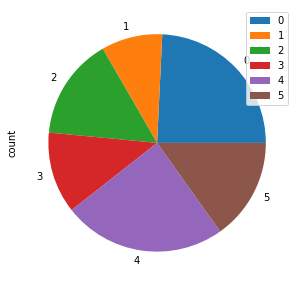

In [445]:
plot = df_rating_grouped.plot.pie(y='count', figsize=(5, 5))

# Histograms

In [446]:
def get_times_active(row):
    end = row['time'].hour
    start = row['time'].hour - row['duration'].seconds//3600
    return_set = set()
    for i in range(end - start + 1):
        return_set.add(str(start + i))
    return return_set

df_processed['hours_active'] = df_processed.apply(get_times_active, axis=1) 
df_processed

,userId,sessionId,date,duration,time,weekday,sceneId,seconds,hours_active
id,,,,,,,,,
2,0,0,2020-01-03,0 days 02:51:08,16:26:43,Friday,7,10268.0,"{15, 14, 16}"
5,1,0,2020-01-03,0 days 02:26:55,14:11:38,Friday,7,8815.0,"{14, 13, 12}"
8,2,0,2020-01-03,0 days 04:50:45,14:57:35,Friday,7,17445.0,"{11, 14, 13, 10, 12}"
10,3,0,2020-01-03,0 days 01:30:19,13:04:44,Friday,7,5419.0,"{13, 12}"
12,4,0,2020-01-03,0 days 00:58:13,11:41:05,Friday,7,3493.0,{11}
...,...,...,...,...,...,...,...,...,...
162,5,6,2020-01-09,0 days 04:09:49,16:01:14,Thursday,0,14989.0,"{15, 14, 13, 16, 12}"
165,6,6,2020-01-09,0 days 02:49:25,12:50:50,Thursday,0,10165.0,"{11, 12, 10}"
168,7,6,2020-01-09,0 days 02:00:30,14:52:09,Thursday,0,7230.0,"{14, 13, 12}"


In [447]:
df_pre_fri_hist = df_processed.loc[df_processed['weekday'] == 'Monday']
df_pre_fri_hist

,userId,sessionId,date,duration,time,weekday,sceneId,seconds,hours_active
id,,,,,,,,,
79,0,3,2020-01-06,0 days 02:22:41,11:25:00,Monday,6,8561.0,"{9, 11, 10}"
82,1,3,2020-01-06,0 days 01:05:57,11:34:33,Monday,6,3957.0,"{11, 10}"
84,2,3,2020-01-06,0 days 03:44:39,14:53:51,Monday,6,13479.0,"{11, 14, 13, 12}"
87,3,3,2020-01-06,0 days 02:51:39,13:51:49,Monday,6,10299.0,"{11, 13, 12}"
90,4,3,2020-01-06,0 days 00:39:39,12:19:22,Monday,6,2379.0,{12}
92,5,3,2020-01-06,0 days 03:33:04,14:40:36,Monday,6,12784.0,"{11, 14, 13, 12}"
94,6,3,2020-01-06,0 days 00:37:14,11:34:21,Monday,6,2234.0,{11}
97,7,3,2020-01-06,0 days 00:36:12,09:43:01,Monday,6,2172.0,{9}
99,8,3,2020-01-06,0 days 02:03:06,12:24:10,Monday,6,7386.0,"{11, 12, 10}"


In [448]:
data_for_hist = {}
            
count = 0
for times in df_pre_fri_hist['hours_active']:
    for time in times:
        data_for_hist[count] = float(time)
        count += 1
    
df_fri_hist = pd.DataFrame(data_for_hist, index = [0])
df_fri_hist = df_fri_hist.reindex(sorted(df_fri_hist.columns), axis=1)
df_fri_hist

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,9.0,11.0,10.0,11.0,10.0,11.0,14.0,13.0,12.0,11.0,...,11.0,14.0,13.0,12.0,11.0,9.0,11.0,12.0,10.0,11.0


In [449]:
df_fri_hist.max(axis=1)[0]

14.0

## Histogram showing concurrent users throughout a day

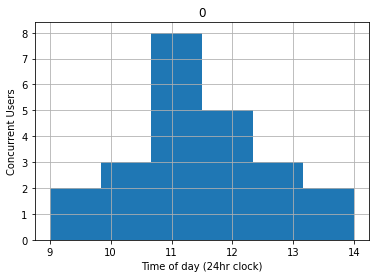

In [450]:
axarr = df_fri_hist.transpose().hist(bins=6)

for ax in axarr.flatten():
    ax.set_xlabel("Time of day (24hr clock)")
    ax.set_ylabel("Concurrent Users")

## Histogram showing length of sessions

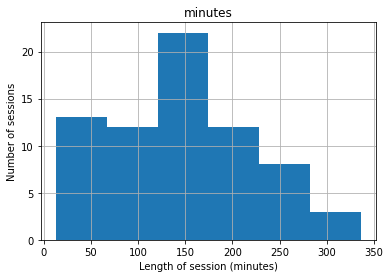

In [451]:
df_sesh_len_hist = df_processed[['duration']].copy()
df_sesh_len_hist['minutes'] = [d.total_seconds()/60 for d in df_processed['duration']]
df_min_hist = df_sesh_len_hist[['minutes']].copy()
axarr = df_min_hist.hist(bins=6)

for ax in axarr.flatten():
    ax.set_xlabel("Length of session (minutes)")
    ax.set_ylabel("Number of sessions")

## Radar graph showing average ratings for each category

In [468]:
df_rating_cat_grouped = pd.DataFrame({'mean' : df_rating.groupby(["rating_cat"])['rating'].mean()}).reset_index()
df_rating_cat_grouped

,rating_cat,mean
0,Cat4,2.00
1,Cat5,4.00
2,Cat6,4.00
3,Chat,2.75
4,Collab Tools,0.50
5,Network,0.00


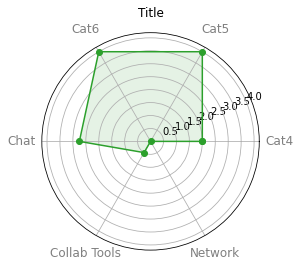

In [469]:
# df = pd.DataFrame({'Col A': ['home', 'other', 'used', 'new', 'service'],
# 'Col B': [6.797, 3.243, 12.567, 8.985, 1.345]})
fig = plt.figure()
ax = fig.add_subplot(111, projection="polar")

# theta has 5 different angles, and the first one repeated
theta = np.arange(len(df_rating_cat_grouped) + 1) / float(len(df_rating_cat_grouped)) * 2 * np.pi
# values has the 5 values from 'mean', with the first element repeated
values = df_rating_cat_grouped['mean'].values
values = np.append(values, values[0])

# draw the polygon and the mark the points for each angle/value combination
l1, = ax.plot(theta, values, color="C2", marker="o", label="Mean rating")
plt.xticks(theta[:-1], df_rating_cat_grouped['rating_cat'], color='grey', size=12)
ax.tick_params(pad=10) # to increase the distance of the labels to the plot
# fill the area of the polygon with green and some transparency
ax.fill(theta, values, 'green', alpha=0.1)

# plt.legend() # shows the legend, using the label of the line plot (useful when there is more than 1 polygon)
plt.title("Title")
plt.show()

In [284]:
dt.datetime.now().timestamp()

1636339105.303118

In [ ]:
# histogram showing concurrent users in a scene (throughout day)
# smiley face rating for users to rate the session (store in data)
# histogram showing length of session for users in a week (timeframe)